In [10]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

In [11]:
CLIENT_ID = '5JF4NL0EOO22IK5JYKC5E1ZJSZ0BYZZQMGD4TMIJNQUOJXUZ'
CLIENT_SECRET = '4QSGYNEDVJHYVBCJAOTDOOZ00BQDFS5KKTLDWQXRKI2XL5JY'
VERSION = '20200410'
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude
def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [12]:
ny_data = get_new_york_data()

In [16]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_stats_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


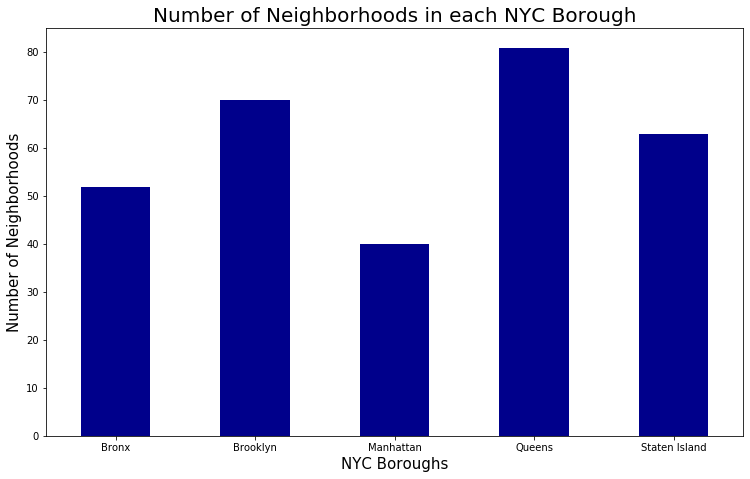

In [17]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(12.5,7.5), color="darkblue")
plt.title('Number of Neighborhoods in each NYC Borough', fontsize = 20)
plt.xlabel('NYC Boroughs', fontsize = 15)
plt.ylabel('Number of Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Manhattan historically is known to have many Italian Americans - it makes up almost a third of the Italian American population in New York City. Thus, for the least amount of neighborhoods, it is more densly populated with Italian Americans. This is a good indicator of where an Italian restaurant should open - there will be a lot of Italians wanting Italian food.

In [18]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_resturants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Resturants in '+Neighborhood+', '+Borough+':'+str(len(italian_resturants)))
    print(row)
    for resturant_detail in italian_resturants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

ayside, Queens:2
['Queens', 'Bayside', 40.76604063281064, -73.7742736306867]
( 153 / 306 ) Italian Resturants in Auburndale, Queens:1
['Queens', 'Auburndale', 40.76172954903262, -73.79176243728061]
( 154 / 306 ) Italian Resturants in Little Neck, Queens:2
['Queens', 'Little Neck', 40.7708261928267, -73.7388977558074]
( 155 / 306 ) Italian Resturants in Douglaston, Queens:1
['Queens', 'Douglaston', 40.76684609790763, -73.7424982072733]
( 156 / 306 ) Italian Resturants in Glen Oaks, Queens:0
['Queens', 'Glen Oaks', 40.74944079974332, -73.71548118999145]
( 157 / 306 ) Italian Resturants in Bellerose, Queens:1
['Queens', 'Bellerose', 40.72857318176675, -73.72012814826903]
( 158 / 306 ) Italian Resturants in Kew Gardens Hills, Queens:0
['Queens', 'Kew Gardens Hills', 40.722578244228046, -73.82087764933566]
( 159 / 306 ) Italian Resturants in Fresh Meadows, Queens:0
['Queens', 'Fresh Meadows', 40.7343944653313, -73.78271337003264]
( 160 / 306 ) Italian Resturants in Briarwood, Queens:0
['Que

In [20]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv')

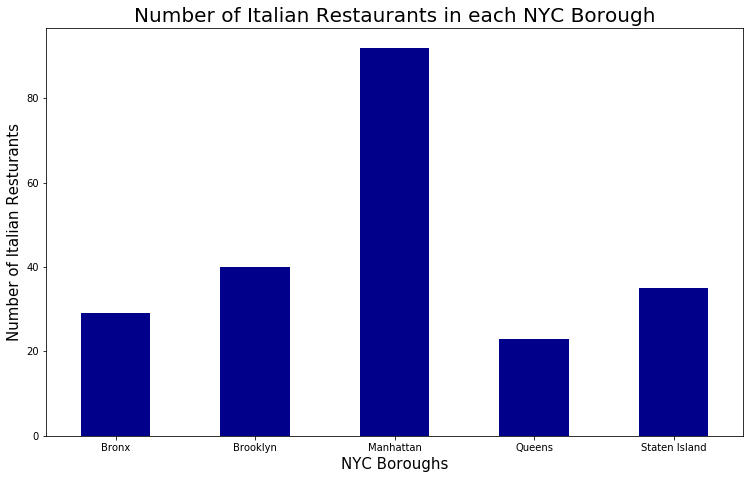

In [21]:
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(12.5,7.5), color = "darkblue")
plt.title('Number of Italian Restaurants in each NYC Borough', fontsize = 20)
plt.xlabel('NYC Boroughs', fontsize = 15)
plt.ylabel('Number of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

It would be ideal to have an Italian restaurant in a borough known to have Italian restaurants. This would help attract more potential customers. Manhattan seems like the best choice so far. Hopefully further research supports this choice.

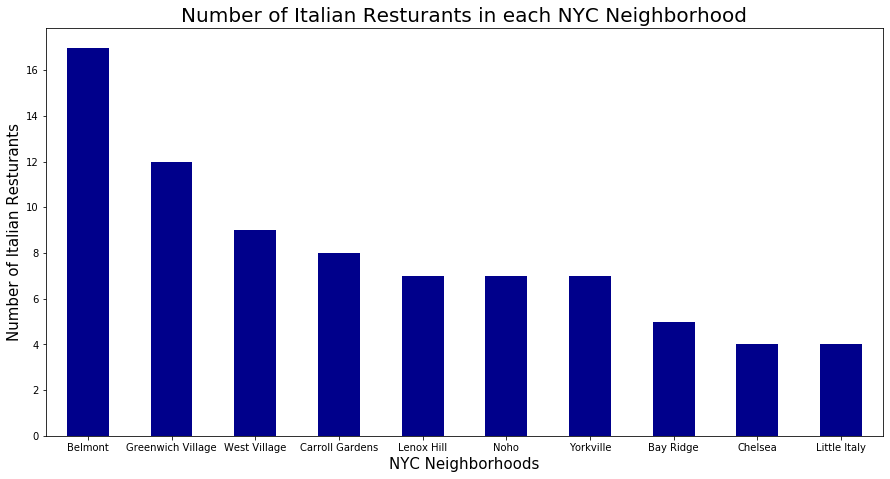

In [22]:

Number_Neighborhoods = 10
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(Number_Neighborhoods).plot.bar(figsize=(15,7.5), color="darkblue")
plt.title('Number of Italian Resturants in each NYC Neighborhood', fontsize = 20)
plt.xlabel('NYC Neighborhoods', fontsize = 15)
plt.ylabel('Number of Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

7/10 of the NYC Neighborhoods above are located in Manhattan. This information further supports that Manhattan seems like the best choice. These Manhattan neighborhoods are Italian restaurant hot spots: Greenwich Village, West Village, Lenox Hill, Noho, Yorkvillille, Little Italy, Chelsea. It would be best to have an Italian restaurant in any of the 7/10 Manhattan neighborhoods, with the exception of Greenwich Village and West Village. This is because there is too much competition - it would be better to start an Italian restaurant in an area with less pre-existing Italian restaurants.

In [31]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venues=get_venues(rating)
        print(venues)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

NameError: name 'rating' is not defined

If one is interested in opening up an Italian restaurant in an area that has good tips and/or 'likes' from customers, those could be used - that is why they are included in the code. But for right now, I am simply sticking to the ratings of the restaurants. Perhaps further down the road, if potential employees are wanting to find an Italian restaurant that provides good tips or a likeable atmosphere, I can include the tips and 'likes' portion.

In [32]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv')

In [33]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

DataError: No numeric types to aggregate

In [36]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

DataError: No numeric types to aggregate